In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!pwd

/home/walml/repos/zoobot/notebooks/multiq


In [3]:
!git pull

Already up-to-date.


In [4]:
import matplotlib
matplotlib.get_backend()

'module://ipykernel.pylab.backend_inline'

In [5]:
import os
import logging
import argparse

import numpy as np
from matplotlib.ticker import StrMethodFormatter

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
import pandas as pd
from astropy.table import Table  # for NSA
from astropy import units as u
from sklearn.metrics import confusion_matrix, roc_curve
from PIL import Image
from scipy.stats import binom
from IPython.display import display, Markdown
print(matplotlib.get_backend())

from shared_astro_utils import astropy_utils, matching_utils

print(matplotlib.get_backend())
from zoobot.estimators import make_predictions, bayesian_estimator_funcs
from zoobot.tfrecord import read_tfrecord
print(matplotlib.get_backend())
from zoobot.uncertainty import discrete_coverage
print(matplotlib.get_backend())
from zoobot.estimators import input_utils, losses
print(matplotlib.get_backend())
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline, default_estimator_params

print(matplotlib.get_backend())

module://ipykernel.pylab.backend_inline
module://ipykernel.pylab.backend_inline
module://ipykernel.pylab.backend_inline
module://ipykernel.pylab.backend_inline
module://ipykernel.pylab.backend_inline
module://ipykernel.pylab.backend_inline


In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)


In [7]:
matplotlib.get_backend()

'module://ipykernel.pylab.backend_inline'

In [8]:
os.chdir('/home/walml/repos/zoobot')

In [9]:
model_name = 'latest_offline'

In [10]:
# Figures will be saved to here

analysis_dir = 'analysis/multiquestion'
save_dir = f'{analysis_dir}/{model_name}'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    
single_model_name = '{}-single'.format(model_name)
single_save_dir = f'{analysis_dir}/{single_model_name}'
if not os.path.exists(single_save_dir):
    os.mkdir(single_save_dir)
assert single_save_dir != save_dir

In [11]:


# NEW_PREDICTIONS = False
NEW_PREDICTIONS = True

### Load the (latest) model under `model_name` folder in `results_dir`

In [12]:
results_dir = 'results'

img_size = 128

tfrecord_loc = f'data/decals/shards/multilabel_{img_size}/eval/s{img_size}_shard_0.tfrecord'

#### Download previously trained model (only if new predictions needed)

#### Download previously-made shards (only if new predictions needed)

### Load original catalog

In [13]:
catalog = pd.read_csv('data/latest_labelled_catalog.csv', dtype={'subject_id': str})

### Predict many rho for the galaxies in tfrecord_loc. Record id_strs to join into catalog later.

**Stop here if you're reloading from saved predictions**

In [14]:
def dummy_acquisition_func(samples):
    return np.random.rand(len(samples))

In [15]:
assert NEW_PREDICTIONS

In [16]:
batch_size = 32
initial_size = 128
final_size = 64
channels = 3

label_cols = [
    'smooth-or-featured_smooth',
    'smooth-or-featured_featured-or-disk',
    'has-spiral-arms_yes',
    'has-spiral-arms_no',
    'spiral-winding_tight',
    'spiral-winding_medium',
    'spiral-winding_loose',
    'bar_strong',
    'bar_weak',
    'bar_no',
    'bulge-size_dominant',
    'bulge-size_large',
    'bulge-size_moderate',
    'bulge-size_small',
    'bulge-size_none'
]

questions = [
    'smooth-or-featured',
    'has-spiral-arms',
    'spiral-winding',
    'bar',
    'bulge-size'
]

model = default_estimator_params.get_model(label_cols, questions, final_size)

checkpoint_dir = f'{results_dir}/{model_name}/results/models'
model.load_weights(checkpoint_dir)


eval_config = default_estimator_params.get_eval_config(tfrecord_loc, label_cols, batch_size, initial_size, final_size, channels)
test_dataset = input_utils.get_input(config=eval_config)

{smooth-or-featured, indices 0 to 1, asked after None: (0, 1), has-spiral-arms, indices 2 to 3, asked after <zoobot.estimators.losses.Answer object at 0x7fa518a0b450>: (2, 3), spiral-winding, indices 4 to 6, asked after <zoobot.estimators.losses.Answer object at 0x7fa518cb0b50>: (4, 6), bar, indices 7 to 9, asked after <zoobot.estimators.losses.Answer object at 0x7fa518a0b450>: (7, 9), bulge-size, indices 10 to 14, asked after <zoobot.estimators.losses.Answer object at 0x7fa518a0b450>: (10, 14)}
Name: smooth-or-featured, start 0, end 1
Name: has-spiral-arms, start 2, end 3
Name: spiral-winding, start 4, end 6
Name: bar, start 7, end 9
Name: bulge-size, start 10, end 14


In [17]:
n_samples = 10

In [18]:
# %timeit predictions = model.predict(test_dataset)

In [19]:
feature_spec = input_utils.get_feature_spec({'id_str': 'string'})
id_str_dataset = input_utils.get_dataset(tfrecord_loc, feature_spec, batch_size=1, shuffle=False, repeat=False)
# for d in id_str_dataset:
#     data = str(d['id_str'].numpy().squeeze())[2:-1]  # remove the stray 'b..'
#     print(data, type(data))
id_strs = [str(d['id_str'].numpy().squeeze())[2:-1] for d in id_str_dataset]
id_strs[:5]

['J224844.07+170151.1',
 'J104246.30+031226.2',
 'J143952.90-001925.4',
 'J113855.91-024452.3',
 'J143037.53-014514.3']

In [20]:
predictions = np.stack([model.predict(test_dataset) for n in range(n_samples)], axis=-1)

[(0, 1), (2, 3), (4, 6), (7, 9), (10, 14)]
0 1
2 3
4 6
7 9
10 14


In [21]:
predictions.shape

(3000, 15, 10)

In [22]:
for batch_x, batch_y in test_dataset:
    print(batch_y.numpy())
    break

[[14. 25. 16.  9.  8.  7.  1.  4.  9. 12.  0.  6. 15.  4.  0.]
 [18. 20. 15.  4.  4.  6.  5.  1.  6. 12.  1.  0.  3. 12.  3.]
 [ 4. 24. 20.  3. 13.  6.  1.  0.  4. 19.  2.  0. 12.  9.  0.]
 [ 6. 28. 24.  4.  9. 15.  0.  1. 10. 17.  0.  0.  8. 19.  1.]
 [15. 20.  9. 11.  3.  5.  1.  0.  4. 16.  0.  1.  1. 16.  2.]
 [ 6. 32. 30.  2.  2. 16. 12. 16.  7.  9.  1. 10. 21.  0.  0.]
 [21. 14. 10.  4.  5.  4.  1.  1.  8.  5.  0.  1.  7.  5.  1.]
 [ 3. 34. 32.  2.  3. 20.  9. 24. 10.  0.  0.  4. 21.  9.  0.]
 [24. 12.  5.  6.  1.  1.  3.  2.  2.  7.  5.  0.  2.  3.  1.]
 [ 1. 37. 30.  6.  0.  8. 22.  6. 16. 14.  0.  1. 18. 14.  3.]
 [ 2. 36. 29.  4.  0.  2. 27. 15. 14.  4.  0.  1.  1. 10. 21.]
 [ 2. 36. 33.  2. 12. 16.  5. 19.  6. 10.  0.  7. 24.  4.  0.]
 [ 8. 33. 27.  6.  7. 12.  8.  8. 11. 14.  1.  8. 21.  3.  0.]
 [13. 26. 17.  8.  1. 11.  5.  1.  6. 18.  1.  5. 19.  0.  0.]
 [ 2. 34. 31.  2. 18. 10.  3.  5. 10. 18.  1.  2. 12. 18.  0.]
 [ 1. 37. 35.  1.  8. 23.  4.  0. 18. 18.  0.  2. 12. 2

In [23]:
labels = np.concatenate([batch_y for (_, batch_y) in test_dataset], axis=0)
labels.shape

(3000, 15)

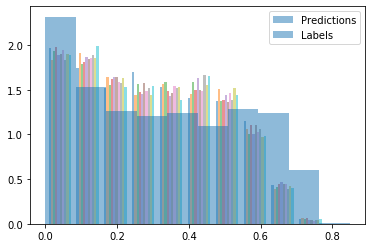

In [24]:
fig, ax = plt.subplots()
ax.hist(predictions[:, 0], alpha=0.5, label='Predictions', density=True)
ax.hist(labels[:, 0] / labels[:, :2].sum(axis=1), alpha=0.5, label='Labels', density=True)
plt.legend()

In [25]:
print(predictions[:, 0].min(), labels[:, 0].min())
print(predictions[:, 0].max(), labels[:, 0].max())

0.0008938066 0.0
0.7776509 129.0


In [26]:
questions = [
    'smooth-or-featured',
    'has-spiral-arms',
    'spiral-winding',
    'bar',
    'bulge-size'
]

# will load labels from shard, in this order
# will predict all label columns, in this order
label_cols = [
    'smooth-or-featured_smooth',
    'smooth-or-featured_featured-or-disk',
    'has-spiral-arms_yes',
    'has-spiral-arms_no',
    'spiral-winding_tight',
    'spiral-winding_medium',
    'spiral-winding_loose',
    'bar_strong',
    'bar_weak',
    'bar_no',
    'bulge-size_dominant',
    'bulge-size_large',
    'bulge-size_moderate',
    'bulge-size_small',
    'bulge-size_none'
]

schema = losses.Schema(label_cols, questions)

{smooth-or-featured, indices 0 to 1, asked after None: (0, 1), has-spiral-arms, indices 2 to 3, asked after <zoobot.estimators.losses.Answer object at 0x7fa45c2df710>: (2, 3), spiral-winding, indices 4 to 6, asked after <zoobot.estimators.losses.Answer object at 0x7fa5120151d0>: (4, 6), bar, indices 7 to 9, asked after <zoobot.estimators.losses.Answer object at 0x7fa45c2df710>: (7, 9), bulge-size, indices 10 to 14, asked after <zoobot.estimators.losses.Answer object at 0x7fa45c2df710>: (10, 14)}


In [27]:
[np.ones(12), np.ones(13)]

[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]

In [28]:
schema.questions

[smooth-or-featured, indices 0 to 1, asked after None,
 has-spiral-arms, indices 2 to 3, asked after <zoobot.estimators.losses.Answer object at 0x7fa45c2df710>,
 spiral-winding, indices 4 to 6, asked after <zoobot.estimators.losses.Answer object at 0x7fa5120151d0>,
 bar, indices 7 to 9, asked after <zoobot.estimators.losses.Answer object at 0x7fa45c2df710>,
 bulge-size, indices 10 to 14, asked after <zoobot.estimators.losses.Answer object at 0x7fa45c2df710>]

In [29]:
predictions.shape

(3000, 15, 10)

In [30]:
acquisitions = acquisition_utils.mutual_info_acquisition_func_multiq(predictions, schema, retirement=40)

In [31]:
acquisitions.shape

(3000, 15)

In [32]:
acquisitions

array([[0.28036147, 0.28036152, 0.25090027, ..., 0.0342347 , 0.07540915,
        0.0221686 ],
       [0.04664192, 0.04664196, 0.25104724, ..., 0.07046406, 0.06685407,
        0.08264476],
       [0.12357778, 0.12357781, 0.10367888, ..., 0.09878788, 0.14059723,
        0.00848955],
       ...,
       [0.27600695, 0.27600693, 0.20925518, ..., 0.07907931, 0.07658649,
        0.04595963],
       [0.11181492, 0.11181496, 0.15409555, ..., 0.13661408, 0.05132487,
        0.01526658],
       [0.25242437, 0.25242438, 0.43611684, ..., 0.14120569, 0.03183366,
        0.27789039]])

In [33]:
single_q_acquisitions = np.array(acquisition_utils.mutual_info_acquisition_func(predictions[:, 0], expected_votes=40))

In [34]:
schema.named_index_groups

{smooth-or-featured, indices 0 to 1, asked after None: (0, 1),
 has-spiral-arms, indices 2 to 3, asked after <zoobot.estimators.losses.Answer object at 0x7fa45c2df710>: (2,
  3),
 spiral-winding, indices 4 to 6, asked after <zoobot.estimators.losses.Answer object at 0x7fa5120151d0>: (4,
  6),
 bar, indices 7 to 9, asked after <zoobot.estimators.losses.Answer object at 0x7fa45c2df710>: (7,
  9),
 bulge-size, indices 10 to 14, asked after <zoobot.estimators.losses.Answer object at 0x7fa45c2df710>: (10,
  14)}

In [35]:
single_q_acquisitions.shape

(3000,)

In [36]:
single_q_acquisitions[:5], acquisitions[0, :5], acquisitions[1, :5]  # smooth mutual acq should be identical, for both answers by symmmetry

(array([0.28036147, 0.04664192, 0.12357778, 0.32527525, 0.22682905]),
 array([0.28036147, 0.28036152, 0.25090027, 0.25090022, 0.0879916 ]),
 array([0.04664192, 0.04664196, 0.25104724, 0.25104723, 0.02274091]))

In [37]:
acquisitions[2, :5], acquisitions[3, :5]  # has-spiral-arms also by symmetry

(array([0.12357778, 0.12357781, 0.10367888, 0.10367889, 0.07377587]),
 array([0.32527525, 0.32527532, 0.34551238, 0.34551244, 0.20259955]))

In [38]:
acquisitions[4, :5], acquisitions[5, :5], acquisitions[6, :5]  # but for spiral winding there are 3 answers so *not* identical

(array([0.22682905, 0.22682904, 0.3910643 , 0.39106427, 0.08138773]),
 array([0.2479257 , 0.24792572, 0.36812983, 0.36812987, 0.09600373]),
 array([0.25183268, 0.25183266, 0.21948575, 0.21948575, 0.0638698 ]))

In [39]:
predictions.shape, acquisitions.shape, len(id_strs)

((3000, 15, 10), (3000, 15), 3000)

In [40]:
def prediction_to_row(prediction, acquisition, id_str):
    row = {
        'id_str': id_str
    }
    for n, col in enumerate(label_cols):
        answer = label_cols[n]
        row[answer + '_prediction'] = prediction[n]
        row[answer + '_acquisition'] = acquisition[n]
        row[answer + '_prediction_mean'] = float(prediction[n].mean())
        row[answer + '_acquisition'] = acquisition[n]
        row['total_acquisition'] = acquisition.sum()
    return row

In [41]:
data = [prediction_to_row(predictions[n], acquisitions[n], id_strs[n]) for n in range(len(predictions))]
predictions_df = pd.DataFrame(data)

In [42]:
predictions_df.head()

,id_str,smooth-or-featured_smooth_prediction,smooth-or-featured_smooth_acquisition,smooth-or-featured_smooth_prediction_mean,total_acquisition,smooth-or-featured_featured-or-disk_prediction,smooth-or-featured_featured-or-disk_acquisition,smooth-or-featured_featured-or-disk_prediction_mean,has-spiral-arms_yes_prediction,has-spiral-arms_yes_acquisition,...,bulge-size_large_prediction_mean,bulge-size_moderate_prediction,bulge-size_moderate_acquisition,bulge-size_moderate_prediction_mean,bulge-size_small_prediction,bulge-size_small_acquisition,bulge-size_small_prediction_mean,bulge-size_none_prediction,bulge-size_none_acquisition,bulge-size_none_prediction_mean
0,J224844.07+170151.1,"[0.46213347, 0.3901563, 0.45157897, 0.414977, ...",0.280361,0.464113,1.677282,"[0.53786653, 0.6098437, 0.54842097, 0.585023, ...",0.280362,0.535887,"[0.6767727, 0.7599947, 0.7702104, 0.7415047, 0...",0.250900,...,0.124836,"[0.61252743, 0.5740846, 0.5750442, 0.63994604,...",0.034235,0.580943,"[0.2328638, 0.23936537, 0.26027346, 0.16900104...",0.075409,0.247477,"[0.013724356, 0.017412992, 0.013944174, 0.0099...",0.022169,0.019737
1,J104246.30+031226.2,"[0.5012236, 0.510462, 0.50752133, 0.50456, 0.5...",0.046642,0.502135,0.963617,"[0.4987764, 0.489538, 0.4924787, 0.49543998, 0...",0.046642,0.497865,"[0.726401, 0.6793781, 0.7368207, 0.6501711, 0....",0.251047,...,0.053175,"[0.3721181, 0.3309496, 0.32598665, 0.31124684,...",0.070464,0.353664,"[0.48719844, 0.53219306, 0.53331465, 0.5445606...",0.066854,0.479048,"[0.07011156, 0.07362245, 0.08219573, 0.0935389...",0.082645,0.093260
2,J143952.90-001925.4,"[0.35475567, 0.28338638, 0.28410617, 0.2224398...",0.123578,0.265868,0.997471,"[0.64524436, 0.7166136, 0.71589386, 0.77756023...",0.123578,0.734131,"[0.7926739, 0.87479967, 0.8594681, 0.89881074,...",0.103679,...,0.039374,"[0.49344474, 0.45768458, 0.59847367, 0.4839584...",0.098788,0.511669,"[0.44506538, 0.49494624, 0.33432433, 0.4660546...",0.140597,0.424824,"[0.0101536, 0.00991718, 0.012217433, 0.0125983...",0.008490,0.013346
3,J113855.91-024452.3,"[0.050721735, 0.08742116, 0.04674108, 0.177200...",0.325275,0.097325,3.345591,"[0.9492783, 0.9125788, 0.95325893, 0.82279974,...",0.325275,0.902675,"[0.9623526, 0.9615341, 0.9828249, 0.8922274, 0...",0.345512,...,0.013017,"[0.22555248, 0.36781597, 0.3189207, 0.2807154,...",0.160678,0.298957,"[0.7213571, 0.6008998, 0.6466216, 0.6605266, 0...",0.139119,0.648954,"[0.04224214, 0.014948034, 0.013388518, 0.04087...",0.118542,0.033314
4,J143037.53-014514.3,"[0.46800488, 0.44249025, 0.3311407, 0.43450177...",0.226829,0.396238,1.804705,"[0.5319951, 0.5575098, 0.6688593, 0.56549823, ...",0.226829,0.603762,"[0.6284485, 0.5850589, 0.8368372, 0.61033314, ...",0.391064,...,0.010311,"[0.1244917, 0.2108291, 0.17001896, 0.26619458,...",0.117020,0.171133,"[0.737654, 0.68378687, 0.7451461, 0.6337728, 0...",0.082750,0.723137,"[0.115056396, 0.08195584, 0.06568584, 0.076656...",0.029927,0.086295


In [43]:
predictions_df['iauname'] = predictions_df['id_str']
df = pd.merge(catalog, predictions_df, how='inner', on='iauname')
len(df)

3000

In [44]:
df.columns.values

array(['subject_id', 'bar_no', 'bar_strong', 'bar_weak',
       'bulge-size_dominant', 'bulge-size_large', 'bulge-size_moderate',
       'bulge-size_none', 'bulge-size_small', 'disk-edge-on_no',
       'disk-edge-on_yes', 'edge-on-bulge_boxy', 'edge-on-bulge_none',
       'edge-on-bulge_rounded', 'has-spiral-arms_no',
       'has-spiral-arms_yes', 'how-rounded_cigar-shaped',
       'how-rounded_in-between', 'how-rounded_round', 'merging_both-v1',
       'merging_major-disturbance', 'merging_merger',
       'merging_minor-disturbance', 'merging_neither-v1', 'merging_none',
       'merging_tidal-debris-v1', 'smooth-or-featured_artifact',
       'smooth-or-featured_featured-or-disk', 'smooth-or-featured_smooth',
       'spiral-arm-count_1', 'spiral-arm-count_2', 'spiral-arm-count_3',
       'spiral-arm-count_4', 'spiral-arm-count_cant-tell',
       'spiral-arm-count_more-than-4', 'spiral-winding_loose',
       'spiral-winding_medium', 'spiral-winding_tight',
       'smooth-or-featured_tot

In [45]:
df['subject_url']

0       https://panoptes-uploads.zooniverse.org/produc...
1       https://panoptes-uploads.zooniverse.org/produc...
2       https://panoptes-uploads.zooniverse.org/produc...
3       https://panoptes-uploads.zooniverse.org/produc...
4       https://panoptes-uploads.zooniverse.org/produc...
                              ...                        
2995    https://panoptes-uploads.zooniverse.org/produc...
2996    https://panoptes-uploads.zooniverse.org/produc...
2997    https://panoptes-uploads.zooniverse.org/produc...
2998    https://panoptes-uploads.zooniverse.org/produc...
2999    https://panoptes-uploads.zooniverse.org/produc...
Name: subject_url, Length: 3000, dtype: object

In [46]:
df['file_loc'] = df['png_loc'].apply(lambda x: '/media/walml/beta/decals/png_native' + x[32:])

In [47]:
df['file_loc']

0       /media/walml/beta/decals/png_native/dr5/J095/J...
1       /media/walml/beta/decals/png_native/dr5/J004/J...
2       /media/walml/beta/decals/png_native/dr5/J104/J...
3       /media/walml/beta/decals/png_native/dr5/J010/J...
4       /media/walml/beta/decals/png_native/dr5/J133/J...
                              ...                        
2995    /media/walml/beta/decals/png_native/dr5/J141/J...
2996    /media/walml/beta/decals/png_native/dr5/J115/J...
2997    /media/walml/beta/decals/png_native/dr5/J171/J...
2998    /media/walml/beta/decals/png_native/dr5/J024/J...
2999    /media/walml/beta/decals/png_native/dr5/J113/J...
Name: file_loc, Length: 3000, dtype: object

In [48]:
# copied from trust_the_model.ipynb
def show_galaxies(df, scale=3, nrows=3, ncols=3):
    fig = plt.gcf()

    plt.figure(figsize=(scale * nrows, scale * ncols * 1.025))
    gs1 = gridspec.GridSpec(nrows, ncols)
    gs1.update(wspace=0.0, hspace=0.0)
    galaxy_n = 0
    for row_n in range(nrows):
        for col_n in range(ncols):
            galaxy = df.iloc[galaxy_n]
            image = Image.open(galaxy['file_loc'])
            ax = plt.subplot(gs1[row_n, col_n])
            ax.imshow(image)
#             ax.text(10, 20, 'Smooth = {:.2f}'.format(galaxy['smooth-or-featured_smooth_fraction']), fontsize=12, color='r')
#             ax.text(10, 50, r'$\rho = {:.2f}$, Var ${:.3f}$'.format(galaxy['median_prediction'], 3*galaxy['predictions_var']), fontsize=12, color='r')
#             ax.text(10, 80, '$L = {:.2f}$'.format(galaxy['bcnn_likelihood']), fontsize=12, color='r')
            ax.axis('off')
            galaxy_n += 1
#     print('Mean L: {:.2f}'.format(df[:nrows * ncols]['bcnn_likelihood'].mean()))
    fig = plt.gcf()
#     fig.tight_layout()
    return fig


In [49]:


def save_top_n(schema, save_dir):
    for question in schema.questions:
        for answer in question.answers:
            fig = show_galaxies(df.sort_values(answer.text + '_prediction_mean', ascending=False)[:9])
            fig.savefig(save_dir + '_' + answer.text + '.png')
            plt.close()

In [50]:
save_dir = 'results/temp'
save_top_n(schema, save_dir)

<Figure size 432x288 with 0 Axes>

In [51]:
# fig, ax = plt.subplots()
# ax.scatter(predictions[:, 0], labels[:, 0] / labels[:, :2].sum(axis=1))
# plt.close()

In [52]:
matplotlib.get_backend()

'module://ipykernel.pylab.backend_inline'

In [53]:
# fig, ax = plt.subplots()
# ax.scatter(predictions[:, 4], labels[:, 4] / labels[:, 4:7].sum(axis=1))

In [54]:
# fig, ax = plt.subplots()
# ax.scatter(predictions[:, 5], labels[:, 5] / labels[:, 4:7].sum(axis=1))

In [55]:
# fig, ax = plt.subplots()
# ax.scatter(predictions[:, 6], labels[:, 6] / labels[:, 4:7].sum(axis=1))

In [56]:
# assert False

AssertionError: 

In [61]:
# to check that the right models have been loaded - should be around 40 for smooth, 0-40 for bars
# plt.hist(sim_model.total_votes), sim_model.total_votes.mean()

### Visualise Posteriors

Check for systematic offset - in general, model seems slightly skewed towards low k?

In [146]:

def get_single_answer_data(df, answer, n=10):
    samples = np.stack(df[answer.text + '_prediction'][:n])
    labels = df[answer.text][:n].values.astype(int)
    total_votes = df[answer.question.text + '_total-votes'][:n].values.astype(int)
    return samples, labels, total_votes
    

In [159]:
def show_population_stats(samples, labels, total_votes, title):
    # sns.set_context('paper')
    sns.set(font_scale=1.)
    sns.set_style('white')
    alpha = 0.5
    # matplotlib.rcParams.update({'font.size': 50}
    
    mean_samples = samples.mean(axis=-1)
    expected_k = mean_samples * total_votes

    # dummy for bins
    fig, (ax0, ax1) = plt.subplots(nrows=2)
    _, bins_rho, _ = ax0.hist(labels/ total_votes, bins=25, alpha=alpha, label='Actual')
    _, bins_k, _ = ax1.hist(labels, bins=25, alpha=alpha, label='Actual')
    plt.close()

    # now for real
    fig, (ax0, ax1) = plt.subplots(nrows=2)

    _, bins, _ = ax0.hist(mean_samples, bins=bins_rho, alpha=alpha, label='Model')
    ax0.hist(labels/ total_votes, bins=bins_rho, alpha=alpha, label='Actual')
    ax0.set_xlabel(r'Vote Fraction $\rho$')
    ax0.set_ylabel('Galaxies')
    ax0.legend()
    ax0.set_xlim([0., 1.])

    _, bins, _ = ax1.hist(expected_k, bins=bins_k, alpha=alpha, label='Model')
    ax1.hist(labels, bins=bins_k, alpha=alpha, label='Actual')
    ax1.set_xlabel(r'Positive Responses $k$')
    ax1.set_ylabel('Galaxies')
    ax1.legend()
    ax1.set_xlim([0, 40])

    ax0.set_title(title)
    fig.tight_layout()
    return fig
    # fig.savefig(os.path.join(save_dir, 'posterior_over_full_sample.png'))
    # fig.savefig(os.path.join(save_dir, 'posterior_over_full_sample.pdf'))

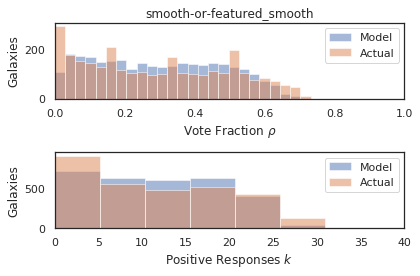

In [160]:

answer = schema.get_answer('smooth-or-featured_smooth')
samples, labels, total_votes = get_single_answer_data(df, answer, n=len(df))
_ = show_population_stats(samples, labels, total_votes, answer.text)

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


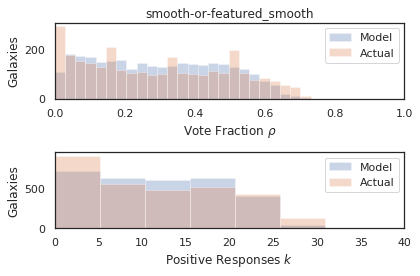

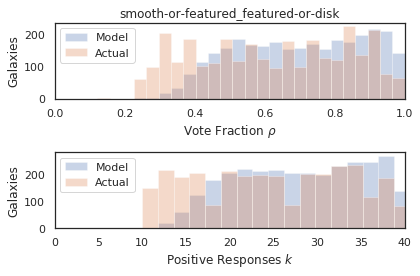

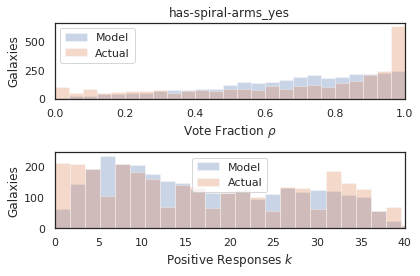

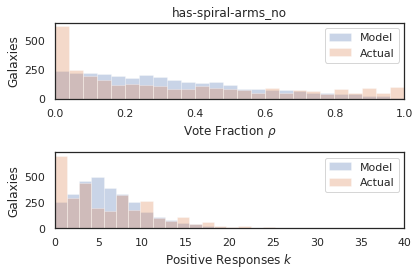

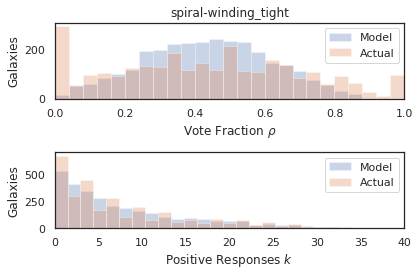

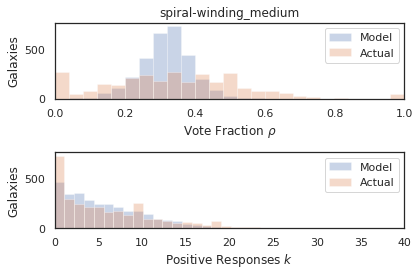

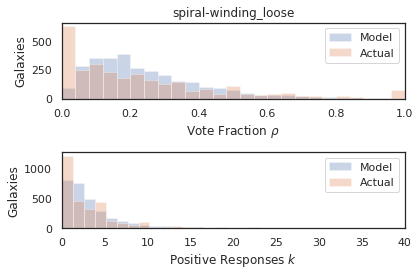

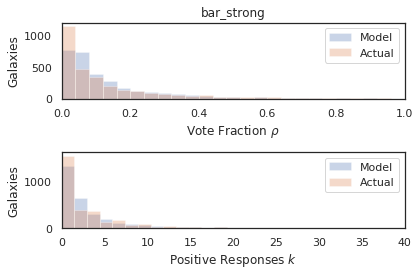

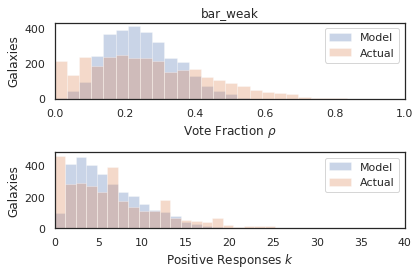

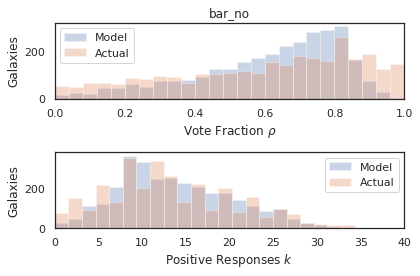

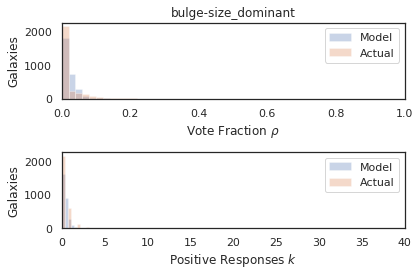

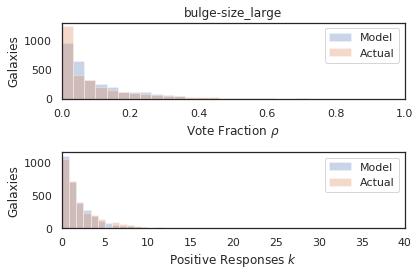

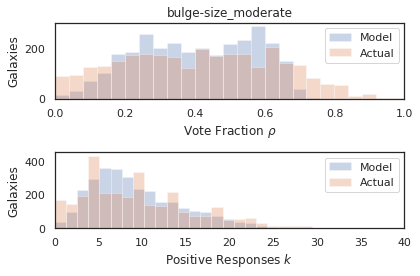

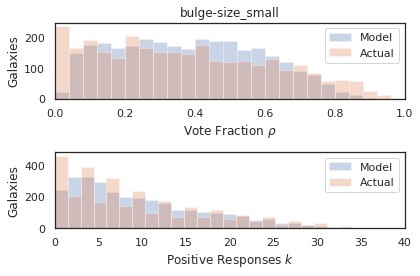

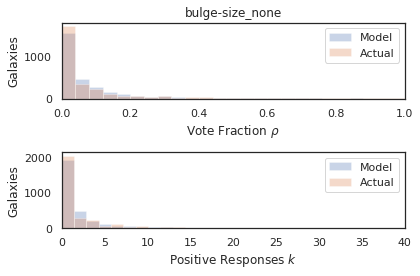

In [156]:
for answer in schema.answers:
    samples, labels, total_votes = get_single_answer_data(df, answer, n=len(df))
    fig = show_population_stats(samples, labels, total_votes, answer.text)
    fig.savefig(save_dir + '/population_distribution_' + answer.text + '.png')

In [63]:
def custom_samples(samples, labels, total_votes):
    sns.set_context('paper', font_scale=1.5)
    fig, axes = plt.subplots(nrows=len(labels), figsize=(3, len(labels)*1.5), sharex=True)
    make_predictions.plot_samples(samples, labels, total_votes, fig, axes, alpha=0.06)
    for ax in axes:
        ax.set_xlim([0, 50])
    
    for n in range(len(labels)):
#         axes[n].set_ylabel(r'$p(v|D)$', visible=True)
        axes[n].set_ylabel(r'$p(v|w)$', visible=True)
        axes[n].yaxis.set_visible(True)
    
    axes[-1].set_xlabel('Volunteer Votes')
    fig.tight_layout()

    axes[0].legend(
        loc='lower center', 
        bbox_to_anchor=(0.5, 1.1),
        ncol=1, 
        fancybox=True, 
        shadow=False
    )
    fig.tight_layout()
    return fig

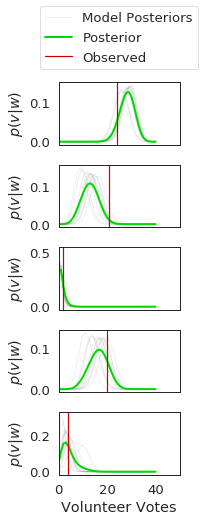

In [74]:

question = 'smooth-or-featured'
answer = 'smooth'
n = 5
samples, labels, total_votes = get_single_answer_data(df, question, answer)
_ = custom_samples(samples, labels, total_votes)

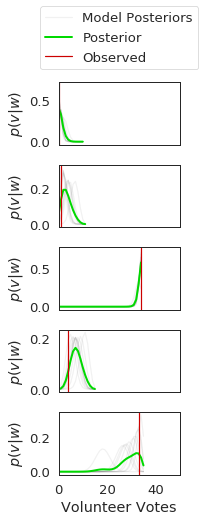

In [75]:

question = 'has-spiral-arms'
answer = 'yes'
n = 5
samples, labels, total_votes = get_single_answer_data(df, question, answer)
_ = custom_samples(samples, labels, total_votes)

In [134]:

def galaxy_posterior_grid(df, schema):
    
    sns.set_context('paper', font_scale=1.5)
    
    scale = 1.5
    
    im_width = 2
    posterior_width = 3
    height = im_width
    
    n_galaxies = len(df)
    n_posteriors = len(schema.answers)
    
    fig = plt.figure(figsize=(scale * (im_width + posterior_width*n_posteriors), (scale * n_galaxies * height)))  # width, height format
    gs = gridspec.GridSpec(len(df) * height, im_width + posterior_width * len(schema.answers))  # y, x format
    image_axes = []
    posterior_axes = []  # (galaxy i.e. row, answer) shape
    
    # create the grid
    for galaxy_n in range(len(df)):
        y_slice = slice(galaxy_n*height, (galaxy_n+1)*height)
        image_axes.append(plt.subplot(gs[y_slice, :im_width]))
        
        temp_galaxy_axes = []
        for answer_n, answer in enumerate(schema.answers):
            x_slice = slice(im_width+answer_n*posterior_width, im_width+(answer_n+1)*posterior_width)
            temp_galaxy_axes.append(plt.subplot(gs[y_slice, x_slice]))
        posterior_axes.append(temp_galaxy_axes)
        
    
    # fill the images
    for ax_n, ax in enumerate(image_axes):
        plot_galaxy(df['file_loc'][ax_n], ax)
    
    # fill the posteriors
    for answer_n, answer in enumerate(schema.answers):
        samples, labels, total_votes = get_single_answer_data(df, answer)
        galaxy_axes = [axes[answer_n] for axes in posterior_axes]
        make_predictions.plot_samples(samples, labels, total_votes, fig, galaxy_axes, alpha=0.06)
    
    # fix x limits for comparison
    for row_n, axes in enumerate(posterior_axes):
        for answer_n, ax in enumerate(axes):
            ax.set_xlim([0, 50])
            if row_n == 0:
                ax.set_title(schema.answers[answer_n].text)
        
#     for n in range(len(labels)):
#         multiple_axes[n].set_ylabel(r'$p(k|N, D)$', visible=True)
#         multiple_axes[n].yaxis.set_visible(True)
#         single_axes[n].set_ylabel(r'$p(k|N, w)$', visible=True)
#         single_axes[n].yaxis.set_visible(True)
#         single_axes[n].yaxis.set_major_locator(plt.NullLocator())
#         multiple_axes[n].yaxis.set_major_locator(plt.NullLocator())
#         if n < len(labels) - 1:
#             single_axes[n].xaxis.set_major_locator(plt.NullLocator())
#             multiple_axes[n].xaxis.set_major_locator(plt.NullLocator())
    
# #     if QUESTION == 'bars':
# #         question = 'Bar'
# #     else:
# #         question = 'Smooth'
# #     single_axes[-1].set_xlabel(r"$k$ '{}' votes, of $N$ total".format(question))
# #     multiple_axes[-1].set_xlabel(r"$k$ '{}' votes, of $N$ total".format(question))
#     fig.tight_layout()

    
#     multiple_axes[0].legend(
#         loc='lower center', 
#         bbox_to_anchor=(0.5, 1.1),
#         ncol=1, 
#         fancybox=True, 
#         shadow=False
#     )

    fig.tight_layout()
    return fig

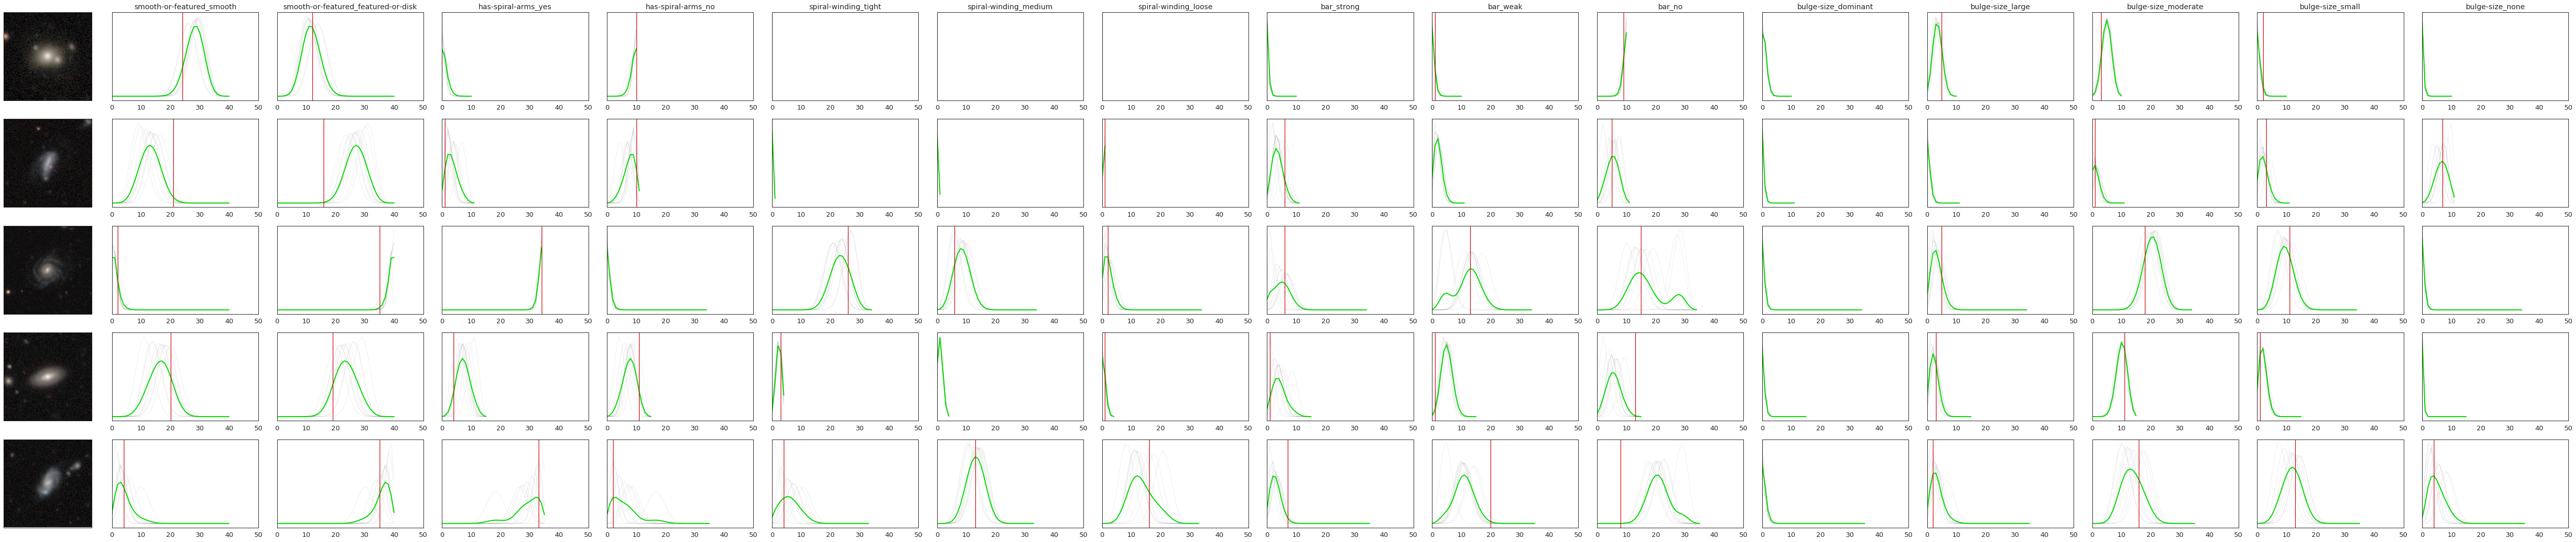

In [136]:
fig = galaxy_posterior_grid(df[:5], schema)
fig.savefig(save_dir + '/grid.pdf')
fig.savefig(save_dir + '/grid.png')

In [91]:

def custom_samples_with_galaxies(samples, labels, total_votes, png_locs):
    
    sns.set_context('paper', font_scale=1.5)
    
    im_width = 2
    single_width = 3
    multiple_width = 3
    height = im_width
    
    fig = plt.figure(figsize=(0.8 * len(labels) * height * 2., 0.8 * (im_width + single_width + multiple_width) * 1.75))
    gs = gridspec.GridSpec(len(labels) * height, im_width + single_width + multiple_width)  # y, x format
    image_axes = []
    single_axes = []
    multiple_axes = []
    for galaxy_n in range(len(labels)):
        x_slice = slice(galaxy_n*height, (galaxy_n+1)*height)
        image_axes.append(plt.subplot(gs[x_slice, :im_width]))
        single_axes.append(plt.subplot(gs[x_slice, im_width:im_width+single_width]))
        multiple_axes.append(plt.subplot(gs[x_slice, im_width+single_width:]))
    

#     fig, axes = plt.subplots(nrows=len(labels), figsize=(3, len(labels)*1.5), sharex=True)
    make_predictions.plot_samples(samples[:, :1], labels, total_votes, fig, single_axes, alpha=0.06)
    for ax in single_axes:
        ax.set_xlim([0, 50])

    make_predictions.plot_samples(samples, labels, total_votes, fig, multiple_axes, alpha=0.06)
    for ax in multiple_axes:
        ax.set_xlim([0, 50])
        
        
    for ax_n, ax in enumerate(image_axes):
        plot_galaxy(png_locs[ax_n], ax)
        
    
    for n in range(len(labels)):
        multiple_axes[n].set_ylabel(r'$p(k|N, D)$', visible=True)
        multiple_axes[n].yaxis.set_visible(True)
        single_axes[n].set_ylabel(r'$p(k|N, w)$', visible=True)
        single_axes[n].yaxis.set_visible(True)
        single_axes[n].yaxis.set_major_locator(plt.NullLocator())
        multiple_axes[n].yaxis.set_major_locator(plt.NullLocator())
        if n < len(labels) - 1:
            single_axes[n].xaxis.set_major_locator(plt.NullLocator())
            multiple_axes[n].xaxis.set_major_locator(plt.NullLocator())
    
#     if QUESTION == 'bars':
#         question = 'Bar'
#     else:
#         question = 'Smooth'
#     single_axes[-1].set_xlabel(r"$k$ '{}' votes, of $N$ total".format(question))
#     multiple_axes[-1].set_xlabel(r"$k$ '{}' votes, of $N$ total".format(question))
    fig.tight_layout()

    single_axes[0].legend(
        loc='lower center', 
        bbox_to_anchor=(0.5, 1.1),
        ncol=1, 
        fancybox=True, 
        shadow=False
    )
    
    multiple_axes[0].legend(
        loc='lower center', 
        bbox_to_anchor=(0.5, 1.1),
        ncol=1, 
        fancybox=True, 
        shadow=False
    )

    
    fig.tight_layout()
    return fig

In [92]:
def plot_galaxy(image_loc, ax, n_examples=10, crop=0):
    im_size = 424
    im = Image.open(image_loc)
#     if QUESTION == 'bars':
#         crop = 120
#     else:
    crop = 35
    cropped_im = im.crop((crop, crop, 424 - crop, 424 - crop))
    ax.imshow(cropped_im)
    ax.grid(False)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)


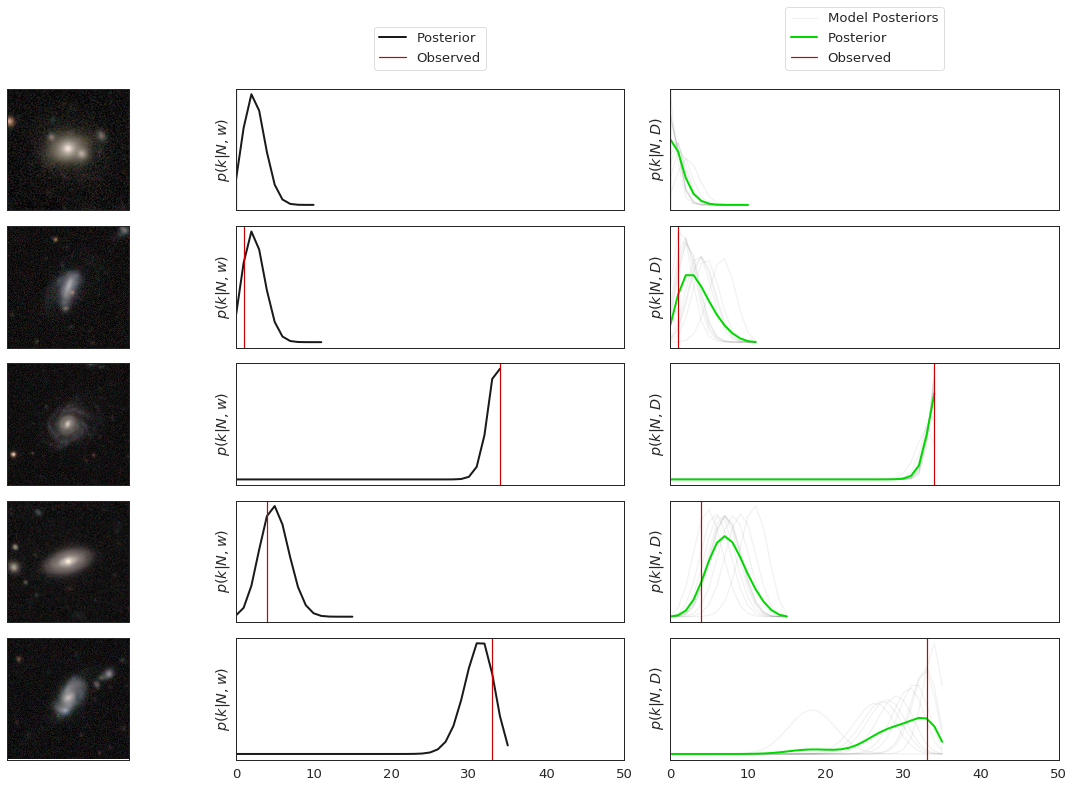

In [93]:
question = 'has-spiral-arms'
answer = 'yes'
n = 5
samples, labels, total_votes = get_single_answer_data(question, answer)
png_locs = df['file_loc'][:n]

# catalog = sim_model.catalog[selected_slice]

_ = custom_samples_with_galaxies(samples, labels, total_votes, png_locs)

In [ ]:
# fig, axes = plt.subplots(1, 10, figsize=(20, 12))
# for ax_n, ax in enumerate(axes):
#     plot_galaxy(sim_model.catalog.iloc[ax_n]['png_loc'], ax)

In [ ]:
# 1 2

In [ ]:
selected = slice(80, 73, -1)  # smooth

# selected = slice(0, 7)

if QUESTION == 'bars':
    selected = slice(0, 7)

In [ ]:
# np.array(sim_model.model.samples)[selected, :]
# np.array(sim_model.labels)[selected]
# sim_model.catalog['smooth-or-featured_total-votes'][selected]

In [ ]:
fig = custom_samples_with_galaxies(sim_model, selected)
# fig.savefig(os.path.join(save_dir, 'mc_model_{}.png'.format(len(np.array(sim_model.labels)[selected]))))
# fig.savefig(os.path.join(save_dir, 'mc_model_{}.pdf'.format(len(np.array(sim_model.labels)[selected]))))

In [ ]:
# be sure to switch label in custom_samples before running this
# fig = custom_samples(np.array(single_sim_model.model.samples)[selected, :1], np.array(single_sim_model.labels)[selected], total_votes=single_sim_model.total_votes)
# fig.savefig(os.path.join(save_dir, 'single_model_{}.png'.format(len(np.array(sim_model.labels)[selected]))))
# fig.savefig(os.path.join(save_dir, 'single_model_{}.eps'.format(len(np.array(sim_model.labels)[selected]))))

In [ ]:
sns.set(font_scale=1.2)
sns.set_style('white')

fig, ax = plt.subplots()
ungrouped_coverage_df = discrete_coverage.evaluate_discrete_coverage(
    sim_model.labels, 
    sim_model.bin_probs)
coverage_df = ungrouped_coverage_df.groupby('max_state_error').agg({'prediction': 'sum', 'observed': 'sum'}).reset_index()

ungrouped_single_coverage_df = discrete_coverage.evaluate_discrete_coverage(
    single_sim_model.labels, 
    single_sim_model.bin_probs)
single_coverage_df = ungrouped_single_coverage_df.groupby('max_state_error').agg({'prediction': 'sum', 'observed': 'sum'}).reset_index()


plt.plot(coverage_df['max_state_error'], coverage_df['prediction'], label='MC Model Expects')
plt.plot(single_coverage_df['max_state_error'], single_coverage_df['prediction'], label='Single Model Expects')
plt.plot(single_coverage_df['max_state_error'], coverage_df['observed'], 'k--', label='Actual')

ax.set_xlabel('Max Allowed Vote Error')
ax.set_ylabel('Galaxies Within Max Error')
ax.legend()
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))  # must expect 'x' kw arg

ax.set_xlim([0, 15])
fig.tight_layout()
fig.savefig(os.path.join(save_dir, 'coverage_comparison_200_samples.png'))
fig.savefig(os.path.join(save_dir, 'coverage_comparison_200_samples.pdf'))

In [ ]:
ungrouped_coverage_df.to_csv(os.path.join(save_dir, QUESTION + '_ungrouped_coverage_df.csv'), index=False)
ungrouped_single_coverage_df.to_csv(os.path.join(save_dir, QUESTION + '_ungrouped_coverage_df.csv'), index=False)

In [ ]:
coverage_df['error'] = coverage_df['prediction'] - coverage_df['observed']
coverage_df['relative_error'] = coverage_df['error'] / coverage_df['observed']
coverage_df.to_csv(os.path.join(save_dir, QUESTION + '_coverage_df.csv'), index=False)
coverage_df.head(20)

In [ ]:
single_coverage_df['error'] = single_coverage_df['prediction'] - single_coverage_df['observed']
single_coverage_df['relative_error'] = single_coverage_df['error'] / single_coverage_df['observed']
single_coverage_df.to_csv(os.path.join(save_dir, QUESTION + '_single_coverage_df.csv'), index=False)
single_coverage_df.head(20)

TODO - I might consider adding an MSE model as a comparison, to hopefully beat. I think this might be quite similar though. Ideally I can compare this with previous work somehow.

In [ ]:
sns.set(font_scale=1.2)
sns.set_style('white')
fig, ax = plt.subplots()
ax.hist(sim_model.abs_rho_error, bins=25)
# ax.axvline(sim_model.mean_abs_rho_error, color='r') 
ax.set_xlim([0, 1.])
ax.set_ylabel('Galaxies')
ax.set_xlabel(r'| Expected $\hat{\rho}$ - observed vote fraction $\frac{k}{N}$ |')
fig.tight_layout()
fig.savefig(os.path.join(save_dir, 'difference_in_rho.png'))
fig.savefig(os.path.join(save_dir, 'difference_in_rho.pdf'))

In [ ]:
sim_model.abs_rho_error.mean(), single_sim_model.abs_rho_error.mean()

In [ ]:
np.sqrt(sim_model.mean_abs_rho_error), np.sqrt(single_sim_model.mean_abs_rho_error)  

In [ ]:
np.sqrt(sim_model.mean_square_rho_error), np.sqrt(single_sim_model.mean_square_rho_error) # this is the rmse

In [ ]:
# alpha = 0.3
# n_bins = 25

# # dummy for bins
# fig, ax = plt.subplots()
# _, bins, _  = ax.hist(sim_model.labels / sim_model.total_votes, bins=n_bins, alpha=alpha, label=r'Observed $\rho$')
# ax.hist(sim_model.mean_rho_prediction, bins=n_bins, alpha=alpha, label=r'Mean Rho Prediction $\hat{\rho}}$')
# # ax.hist(single_sim_model.mean_rho_prediction, bins=bins, alpha=alpha, label=r'Single Rho Prediction $\hat{\rho}}$')

# fig, ax = plt.subplots()
# sns.set(font_scale=1.)
# sns.set_style('white')

# ax.hist(sim_model.mean_rho_prediction, bins=bins, alpha=alpha, label=r'Mean Rho Prediction $\hat{\rho}}$')
# # ax.hist(single_sim_model.mean_rho_prediction, bins=bins, alpha=alpha, label=r'Single Rho Prediction $\hat{\rho}}$')
# ax.hist(sim_model.labels / sim_model.total_votes, bins=bins, alpha=alpha, label=r'Observed $\rho$')
# ax.legend()
# ax.set_xlim([0., 1.])
# ax.set_ylabel('Galaxies')
# ax.set_xlabel(r'Typical vote fraction $\rho$')
# fig.tight_layout()
# fig.savefig(os.path.join(save_dir, 'typical_vote_fraction_distribution.png'))

# This is a repeat of the above histograms

In [ ]:
np.sum(sim_model.mean_rho_prediction > 0.5), np.sum(single_sim_model.mean_rho_prediction > 0.5), np.sum((sim_model.labels / sim_model.total_votes) > 0.5)

In [ ]:
(sim_model.labels / sim_model.total_votes).min(), (sim_model.labels / sim_model.total_votes).max()

In [ ]:
sim_model.mean_rho_prediction.min(), sim_model.mean_rho_prediction.max()

In [ ]:
single_sim_model.mean_rho_prediction.min(), single_sim_model.mean_rho_prediction.max()

In [ ]:
sim_model.total_votes

## Save DataFrame of predictions + catalog (GZ2) for use elsewhere

In [ ]:
import json

In [ ]:
response_df = pd.DataFrame(data={
    'total_votes': sim_model.total_votes, 
    'k': sim_model.labels, 
    'vote_fraction': (sim_model.labels / sim_model.total_votes), 
    'rho_prediction': sim_model.mean_rho_prediction
#     'png_loc': sim_model.catalog.png_loc
})
safe_catalog_cols = list(set(sim_model.catalog.columns.values) - set(['total_votes', 'ra_subject', 'dec_subject']))
df = pd.concat([response_df, sim_model.catalog[safe_catalog_cols]], axis=1)
df['smooth'] = df['vote_fraction'] > 0.5
df['confidence_proxy'] = np.abs(0.5 - df['rho_prediction'])
df['rho_predictions'] = 0
for n in range(len(df)):
    df['rho_predictions'][n] = json.dumps(list(sim_model.model.samples[n, :]))
    df = df.sort_values('confidence_proxy', ascending=False)

In [ ]:
df['rho_predictions']

In [ ]:
df.head()

In [ ]:
df.to_parquet('/data/repos/zoobot/notebooks/{}_test_predictions_and_gz2_catalog.parquet'.format(QUESTION))

### Replicate (ish) Sanchez 2017 ROC Curves

In [ ]:
confusion_matrix((sim_model.labels / sim_model.total_votes) > 0.5, sim_model.mean_rho_prediction > 0.5)

In [ ]:
 1 - ((66 + 99) / (490 + 1845 + 66 + 99))

In [ ]:
 1 - ((189 + 81) / (1858 + 189 + 81 + 372))

In [ ]:
fig, ax = plt.subplots()
sns.set(font_scale=1.2)
sns.set_style('white')

fpr, tpr, _ = roc_curve(df['smooth'], df['rho_prediction'])
ax.plot(fpr, tpr, label='All')
df_low_entropy = df[df['confidence_proxy'] > 0.3]
fpr, tpr, _ = roc_curve(df_low_entropy['smooth'], df_low_entropy['rho_prediction'])
ax.plot(fpr, tpr, label=r'"High Confidence" i.e. $\hat{\rho} < 0.2$ or $\hat{\rho} > 0.8$')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

fig.tight_layout()
fig.savefig(os.path.join(save_dir, 'roc_curve.png'))
fig.savefig(os.path.join(save_dir, 'roc_curve.pdf'))

In [ ]:
len(df), len(df_low_entropy)

### Replicate(ish) Khan 2018 Confusion Matrices

> After selecting the OBJIDs from Table 2 based on the probability thresholds of 0.985 and 0.926 for spirals and ellipticals respectively,

In [ ]:
df.sample(1)

In [ ]:
cdf_array = binom.cdf((df['total_votes'] / 2.).astype(int), df['total_votes'], df['rho_prediction'])

In [ ]:
(df['total_votes'] / 2.).astype(int).sample(10)

In [ ]:
df['total_votes'].sample(10)

In [ ]:
df['rho_prediction'].sample(10)

In [ ]:
plt.hist(cdf_array, bins=30)

In [ ]:
binom.cdf(20, 40, 0.88)

In [ ]:
sum(1 - cdf_array > 0.985)

In [ ]:
sum(cdf_array > 0.926)

In [ ]:
high_prob_df = df[(cdf_array < (1 - 0.985)) | (cdf_array > 0.926)]

In [ ]:
len(high_prob_df)

In [ ]:
if QUESTION == 'smooth':
    spiral_pc_to_keep = 516 / 6677
    n_spirals = int(len(df) * spiral_pc_to_keep)
    elliptical_pc_to_keep = 550 / 5904
    n_ellipticals = int(len(df) * elliptical_pc_to_keep)
    print(spiral_pc_to_keep, n_spirals, elliptical_pc_to_keep, n_ellipticals)
    high_prob_df = pd.concat([
        df.sort_values('rho_prediction')[:n_spirals],
        df.sort_values('rho_prediction', ascending=False)[:n_ellipticals]
    ])
if QUESTION == 'bars':
    n_to_keep = int(len(df) * 0.08)
    high_prob_df = pd.concat([
        df.sort_values('rho_prediction')[:int(n_to_keep/2)],
        df.sort_values('rho_prediction', ascending=False)[:int(n_to_keep/2)]
    ])



In [ ]:
high_prob_df.sample(20)

In [ ]:
confusion_matrix(high_prob_df['vote_fraction'] >= 0.5, high_prob_df['rho_prediction'] >= 0.5)

In [ ]:
error = high_prob_df[~(high_prob_df['vote_fraction'] > 0.5) & (high_prob_df['rho_prediction'] > 0.5)]

In [ ]:
error

In [ ]:
error['vote_fraction'] > 0.5, error['rho_prediction'] > 0.5

In [ ]:
img = Image.open(error.iloc[0]['png_loc'])
plt.imshow(img)
fontdict = {'size': 16, 'color': 'white'}
plt.text(30, 360, r'Expected vote frac $\hat{\rho}$: 0.80', fontdict=fontdict)
plt.text(30, 400, r'Observed vote frac $\frac{k}{N}$: 0.50', fontdict=fontdict)
plt.axis('off')
plt.savefig(os.path.join(save_dir, 'high_prob_error_0.png'))
plt.savefig(os.path.join(save_dir, 'high_prob_error_0.eps'))

In [ ]:
# img = Image.open(error.iloc[1]['png_loc'])
# plt.imshow(img)
# fontdict = {'size': 16, 'color': 'white'}
# plt.text(30, 360, r'Expected vote frac $\hat{\rho}$: 0.13', fontdict=fontdict)
# plt.text(30, 400, r'Observed vote frac $\frac{k}{N}$: 0.54', fontdict=fontdict)
# plt.axis('off')
# plt.savefig(os.path.join(save_dir, 'high_prob_error_1.png'))
# plt.savefig(os.path.join(save_dir, 'high_prob_error_1.eps'))

In [ ]:
confusion_matrix(df['vote_fraction'][:int(len(df) / 2)] > 0.5, df['rho_prediction'][:int(len(df) / 2)] > 0.5)

In [ ]:
if QUESTION == 'smooth':
    labels = ['Smooth', 'Featured']
    
#     cm = np.array([[ 232,    2], [   0, 191]])
#     name = 'confusion_matrix_high_confidence'
    
    cm = np.array([[ 490,   66],
       [  99, 1845]])
    name = 'confusion_matrix'
    
if QUESTION == 'bars':
    labels = ['No Bar', 'Bar']
    cm = np.array([[100,    0], [   0,   100]])
    name = 'confusion_matrix_high_confidence'
    
#     cm = np.array([[1858,    81], [   189,   372]])
#     name = 'confusion_matrix'

sns.set(font_scale=3.)
sns.set_style('white')

fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=False, square=True, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Observed')
fig.tight_layout()
fig.savefig(os.path.join(save_dir, '{}.png'.format(name)))
fig.savefig(os.path.join(save_dir, '{}.pdf'.format(name)))

In [ ]:
1 - (8 / (1159 + 83 + 8))

In [ ]:
# sim_model.export_performance_metrics(save_dir)

In [ ]:
# Draw a galaxy, infer a range of p, redraw, and measure accuracy - work in progress

### Plot other standard acquisition visualisations

In [ ]:
new_acquisition_viz = False
if new_acquisition_viz:
    image_locs = sim_model.catalog['png_loc']
    images = np.stack([np.array(Image.open(loc)) for loc in image_locs])
    assert images.shape == (2500, 424, 424, 3)
    acquisition_utils.save_acquisition_examples(images, sim_model.mutual_info, 'mutual_info', save_dir)

In [ ]:
# fig, row = plt.subplots(ncols=3, figsize=(12, 4))

In [ ]:
# row = sim_model.acquisition_vs_volunteer_votes(row)

### Visualise Selection of Catalog Features w.r.t. Acquisition Function

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(20, 12))
gs = gridspec.GridSpec(6, 5, figure=fig)

#### Smooth Votes

In [ ]:
ax0 = plt.subplot(gs[:4, :])
sns.scatterplot(
    np.array(sim_model.catalog['smooth-or-featured_smooth_fraction'] * 40).astype(int),
    sim_model.model.acquisitions, hue=np.array(sim_model.model.acquisitions) > np.array(sim_model.model.acquisitions[103]),
    ax=ax0)
ax0.set_ylabel('Mutual Information')
ax0.set_xlabel('Smooth Votes')
ax0.legend([r'Top 10% $\mathcal{I}$', r'Bottom 90% $\mathcal{I}$'])

In [ ]:
ax1 = plt.subplot(gs[4:, :])
ax1.hist(np.array(sim_model.labels * 40).astype(int), density=True, alpha=0.4)
ax1.hist(np.array(sim_model.labels * 40).astype(int)[:200], density=True, alpha=0.4)
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Smooth Votes')

In [ ]:
plt.savefig(os.path.join(save_dir, 'temp.png'))

#### Redshift

In [ ]:
fig, ax = plt.subplots()
sns.jointplot(np.array(sim_model.labels * 40).astype(int), sim_model.catalog['redshift'], kind='kde')
ax0.set_ylabel('Redshift')
ax0.set_xlabel('Volunteer Votes')

In [ ]:
ax0 = plt.subplot(gs[:2, :])
sns.jointplot(np.array(sim_model.labels * 40).astype(int), sim_model.catalog['redshift'], kind='kde', ax=ax0)
ax0.set_ylabel('Redshift')
ax0.set_xlabel('Volunteer Votes')

In [ ]:
ax0 = plt.subplot(gs[:2, :])
sns.jointplot(sim_model.catalog['redshift'], sim_model.model.acquisitions, ax=ax0)
ax0.set_ylabel('Mutual Information')
ax0.set_xlabel('Redshift')

In [ ]:
ax1 = plt.subplot(gs[4:, :])

ax1.hist(sim_model.catalog['redshift'], density=True, alpha=0.4)
# ax1.hist(sim_model.catalog['redshift'], density=True, alpha=0.4)
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Smooth Votes')
# TODO sort by mutual information

### Below here is only relevant for DECALS, with extra questions. TODO update with GZ2 merger options?

In [ ]:
assert False

In [ ]:
merger_strs

In [ ]:
merger_label = 'merging_major-disturbance'

In [ ]:
ax0 = plt.subplot(gs[:2, :])
sns.scatterplot(sim_model.catalog[merger_label], sim_model.model.mutual_info, ax=ax0)
ax0.set_ylabel('Mutual Information')
ax0.set_xlabel(merger_label)

In [ ]:
_ = plt.hist(sim_model.catalog[merger_label], bins=40)

In [ ]:
featured_no_merger = sim_model.model.mutual_info[(sim_model.catalog[merger_label] == 0) & (sim_model.catalog['smooth-or-featured_smooth_fraction'] < 0.4)]
featured_merger = sim_model.model.mutual_info[(sim_model.catalog[merger_label] > 0) & (sim_model.catalog['smooth-or-featured_smooth_fraction'] < 0.4)]

In [ ]:
featured_no_merger.mean()

In [ ]:
featured_merger.mean()

In [ ]:
fig, ax = plt.subplots()

In [ ]:
ax.hist(featured_no_merger, alpha=0.3, density=True)

In [ ]:
ax.hist(featured_merger, alpha=0.3, density=True)

In [ ]:
fig

In [ ]:
ax = sns.scatterplot(
    sim_model.catalog['smooth-or-featured_artifact'], 
    sim_model.model.mutual_info, 
    hue=sim_model.model.mutual_info > sim_model.model.mutual_info[103])
ax.set_xlim([0, 14.5])

In [ ]:
sns.regplot(
    sim_model.catalog['smooth-or-featured_artifact'], 
    sim_model.model.mutual_info)

In [ ]:
fig, ax = plt.subplots()

In [ ]:
ax.hist(
    sim_model.catalog['smooth-or-featured_artifact'][sim_model.model.mutual_info > sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)
ax.hist(
    sim_model.catalog['smooth-or-featured_artifact'][sim_model.model.mutual_info < sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)

In [ ]:
fig

In [ ]:
has-spiral-arms_yes
spiral-winding_prediction-encoded

In [ ]:
sns.scatterplot(
    sim_model.catalog['has-spiral-arms_yes'][sim_model.catalog['smooth-or-featured_smooth_fraction'] < 0.5], 
    sim_model.model.mutual_info[sim_model.catalog['smooth-or-featured_smooth_fraction'] < 0.5], 
    hue=sim_model.model.mutual_info > sim_model.model.mutual_info[100])

In [ ]:
fig, ax = plt.subplots()
ax.hist(
    sim_model.catalog['has-spiral-arms_yes'][sim_model.model.mutual_info > sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)
ax.hist(
    sim_model.catalog['has-spiral-arms_yes'][sim_model.model.mutual_info < sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)

In [ ]:
fig, ax = plt.subplots()
ax.hist(
    sim_model.catalog['redshift'][sim_model.model.mutual_info > sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)
ax.hist(
    sim_model.catalog['redshift'][sim_model.model.mutual_info < sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)

In [ ]:
fig, ax = plt.subplots()
ax.hist(
    sim_model.catalog['merging_major-disturbance'][sim_model.model.mutual_info > sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)
ax.hist(
    sim_model.catalog['merging_major-disturbance'][sim_model.model.mutual_info < sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)

In [ ]:
for merger_label in merger_strs:
    print('\n' + merger_label)
    print(sim_model.model.mutual_info[sim_model.catalog[merger_label] > 1].mean())
    print(sim_model.model.mutual_info[sim_model.catalog[merger_label] == 1].mean())

In [ ]:
data = [
    {'Volunteer Response': 'Merging', 'Mean Mutual Information': sim_model.model.mutual_info[sim_model.catalog['merging_both-v1'] > 1].mean()},
    {'Volunteer Response': 'Major Disturbance', 'Mean Mutual Information': sim_model.model.mutual_info[sim_model.catalog['merging_major-disturbance'] > 1].mean()},
    {'Volunteer Response': 'Minor Disturbance', 'Mean Mutual Information': sim_model.model.mutual_info[sim_model.catalog['merging_minor-disturbance'] > 1].mean()},
    {'Volunteer Response': 'No Disturbance', 'Mean Mutual Information': sim_model.model.mutual_info[sim_model.catalog['merging_none'] > 20].mean()}
    ]

In [ ]:
df = pd.DataFrame(data)

In [ ]:
df.head()

In [ ]:
fig, ax = plt.subplots()
ax = sns.barplot(data=df, y='Volunteer Response', x='Mean Mutual Information', ax=ax)
ax.set_xlim([0.2, 0.36])
fig.tight_layout()

In [ ]:
print(sim_model.model.mutual_info[(sim_model.catalog['merging_minor-disturbance'] + sim_model.catalog['merging_major-disturbance']) > 0].mean())
print(sim_model.model.mutual_info[(sim_model.catalog['merging_minor-disturbance'] + sim_model.catalog['merging_major-disturbance']) == 0].mean())

In [ ]:
plt.hist(sim_model.catalog['merging_tidal-debris-v1'], bins=40)